In [1]:
# ============================================================
# 0‑01  Install core libraries
# ============================================================
!pip install --quiet torch torchvision tqdm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# ============================================================
# 0‑02  Imports, global config & reproducibility
# ============================================================
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np, random, copy, matplotlib.pyplot as plt, time
from tqdm import tqdm

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed); torch.backends.cudnn.deterministic = True
set_seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# ============================================================
# 0‑03  Simple CNN & data utilities
# ============================================================
class SimpleCNN(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*8*8, 512), nn.ReLU(),
            nn.Linear(512, n_classes)
        )
    def forward(self, x): return self.classifier(self.features(x))

# --- data helpers -----------------------------------------------------------
def get_cifar10(download=True):
    tf = transforms.Compose([transforms.ToTensor()])
    train = datasets.CIFAR10('./data', train=True,  download=download, transform=tf)
    test  = datasets.CIFAR10('./data', train=False, download=download, transform=tf)
    return train, test

def iid_partition(dataset, n_clients):
    idxs = np.random.permutation(len(dataset))
    return np.array_split(idxs, n_clients)

def make_dataloaders(trainset, testset, n_clients=20, batch=64):
    parts = iid_partition(trainset, n_clients)
    client_loaders = [DataLoader(Subset(trainset, ids), batch, shuffle=True) for ids in parts]
    test_loader   = DataLoader(testset, 256, shuffle=False)
    return client_loaders, test_loader


In [7]:
# ============================================================
# 0‑04  Client–Server classes & FedAvg aggregation
# ============================================================

class Client:
    def __init__(self, cid, dataloader):
        self.cid, self.dl = cid, dataloader
    def train(self, global_state, epochs=2, lr=0.01):
        model = SimpleCNN().to(device)
        model.load_state_dict(global_state)
        model.train()
        opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        loss_fn = nn.CrossEntropyLoss()
        for _ in range(epochs):
            for x, y in self.dl:
                x, y = x.to(device), y.to(device)
                opt.zero_grad(); loss_fn(model(x), y).backward(); opt.step()
        return model.state_dict()

class Server:
    def __init__(self, clients, test_dl):
        self.global_model = SimpleCNN().to(device)
        self.clients, self.test_dl = clients, test_dl
        self.hist = []
    def _aggregate(self, client_states):
        new_state = copy.deepcopy(client_states[0])
        for k in new_state:
            new_state[k] = torch.stack([c[k].float() for c in client_states]).mean(0)
        self.global_model.load_state_dict(new_state)
    @torch.no_grad()
    def _evaluate(self):
        self.global_model.eval(); correct = total = 0
        for x, y in self.test_dl:
            x, y = x.to(device), y.to(device)
            correct += (self.global_model(x).argmax(1) == y).sum().item()
            total   += y.size(0)
        acc = correct / total; self.hist.append(acc); return acc
    def train(self, rounds=50, epochs=2, frac=1.0):
        start = time.time()
        for r in range(rounds):
            sampled = random.sample(self.clients, int(frac * len(self.clients)))
            client_states = [c.train(self.global_model.state_dict(), epochs) for c in sampled]
            self._aggregate(client_states)
            acc = self._evaluate()
            if r == 0 or (r + 1) % 10 == 0:
                print(f'Round {r+1:02d}/{rounds} · acc={acc:.3f}')
        print(f'Total time: {time.time() - start:.1f}s')


Round 01/50 · acc=0.242
Round 10/50 · acc=0.527
Round 20/50 · acc=0.623
Round 30/50 · acc=0.680
Round 40/50 · acc=0.701
Round 50/50 · acc=0.713
Total time: 704.8s


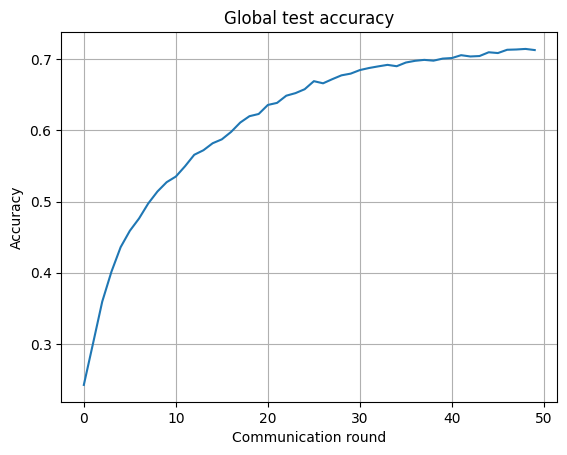

In [8]:
# ============================================================
# 0‑05  Run experiment & plot results
# ============================================================
train_set, test_set = get_cifar10()
client_loaders, test_loader = make_dataloaders(train_set, test_set, n_clients=20)
clients = [Client(i, dl) for i, dl in enumerate(client_loaders)]
server = Server(clients, test_loader)
server.train(rounds=50, epochs=2)

plt.plot(server.hist)
plt.title('Global test accuracy')
plt.xlabel('Communication round'); plt.ylabel('Accuracy'); plt.grid(); plt.show()


In [9]:
# ============================================================
# 1‑01  Dirichlet & label‑skew partition helpers
# ============================================================
from collections import Counter, defaultdict

def dirichlet_partition(dataset, n_clients, alpha=0.5, n_classes=10, seed=42):
    """
    Split indices with class‑wise Dirichlet(α) sampling.
    Returns: list[ ndarray(indices) ] length = n_clients
    """
    np.random.seed(seed)
    labels = np.array(dataset.targets)
    idx_by_class = [np.where(labels == c)[0] for c in range(n_classes)]
    client_indices = [[] for _ in range(n_clients)]

    for c in range(n_classes):
        proportions = np.random.dirichlet(np.repeat(alpha, n_clients))
        # Balance to dataset size
        proportions = (proportions / proportions.sum()) * len(idx_by_class[c])
        proportions = proportions.astype(int)

        np.random.shuffle(idx_by_class[c])
        splits = np.split(idx_by_class[c], np.cumsum(proportions)[:-1])
        for i, ids in enumerate(splits):
            client_indices[i].extend(ids.tolist())

    # shuffle each client’s list for DataLoader randomness
    for ids in client_indices: np.random.shuffle(ids)
    return [np.array(ids) for ids in client_indices]

def make_dataloaders_non_iid(trainset, testset, n_clients=20, batch=64, alpha=0.5):
    parts = dirichlet_partition(trainset, n_clients, alpha=alpha)
    client_loaders = [DataLoader(Subset(trainset, ids), batch, shuffle=True) for ids in parts]
    test_loader   = DataLoader(testset, 256, shuffle=False)
    return client_loaders, test_loader, parts  # return raw parts for plotting


In [10]:
# ============================================================
# 1‑02  Data‑distribution visualizer
# ============================================================
def plot_client_histogram(parts, n_clients=20, n_classes=10):
    class_counts = np.zeros((n_clients, n_classes), dtype=int)
    for i, ids in enumerate(parts):
        lbls = [train_set.targets[j] for j in ids]
        cnt  = Counter(lbls)
        for c in range(n_classes):
            class_counts[i, c] = cnt.get(c, 0)

    fig, ax = plt.subplots(figsize=(8, 4))
    im = ax.imshow(class_counts, aspect='auto', cmap='viridis')
    ax.set_xlabel('Class label'); ax.set_ylabel('Client ID')
    ax.set_title('Samples per class per client')
    plt.colorbar(im, ax=ax, fraction=.02)
    plt.show()


In [11]:
# ============================================================
# 1‑03  FedProx Client (proximal term mu)
# ============================================================
class FedProxClient(Client):
    def __init__(self, cid, dataloader, mu=0.001):
        super().__init__(cid, dataloader)
        self.mu = mu

    def train(self, global_state, epochs=2, lr=0.01):
        model = SimpleCNN().to(device)
        model.load_state_dict(global_state)
        model.train()
        global_params = {k: v.clone().detach().to(device) for k, v in global_state.items()}

        opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        loss_fn = nn.CrossEntropyLoss()

        for _ in range(epochs):
            for x, y in self.dl:
                x, y = x.to(device), y.to(device)
                opt.zero_grad()
                ce_loss = loss_fn(model(x), y)
                # --- proximal term -------------------------------------------------
                prox_loss = 0.0
                for name, param in model.named_parameters():
                    prox_loss += ((param - global_params[name]) ** 2).sum()
                loss = ce_loss + (self.mu / 2) * prox_loss
                loss.backward(); opt.step()
        return model.state_dict()


=== Training FedAvg on IID split ===
Round 01/50 · acc=0.280
Round 10/50 · acc=0.538
Round 20/50 · acc=0.629
Round 30/50 · acc=0.684
Round 40/50 · acc=0.704
Round 50/50 · acc=0.711
Total time: 668.6s


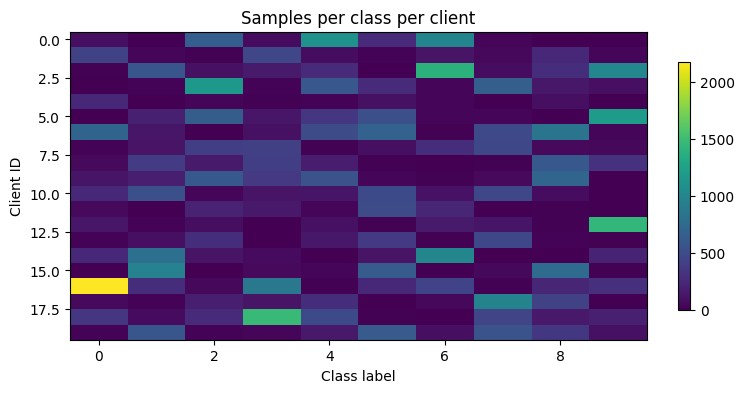


=== Training FedProx (μ=0.001) on Non‑IID Dirichlet α=0.5 ===
Round 01/50 · acc=0.198
Round 10/50 · acc=0.496
Round 20/50 · acc=0.590
Round 30/50 · acc=0.645
Round 40/50 · acc=0.658
Round 50/50 · acc=0.684
Total time: 811.8s


In [ ]:
# ============================================================
# 1‑04  Train FedAvg (IID) vs FedProx (Non‑IID)
# ============================================================
# --  A. IID / FedAvg baseline  ------------------------------------------------
train_set, test_set = get_cifar10(download=True)         # already defined in 0‑03
iid_clients_dl, test_loader = make_dataloaders(train_set, test_set, n_clients=20)
iid_clients = [Client(i, dl) for i, dl in enumerate(iid_clients_dl)]
server_iid = Server(iid_clients, test_loader)
print('=== Training FedAvg on IID split ===')
server_iid.train(rounds=50, epochs=2)

# --  B. Non‑IID Dirichlet / FedProx  -----------------------------------------
alpha_val = 0.5                                           # smaller α -> more skew
non_iid_dls, test_loader, parts = make_dataloaders_non_iid(
    train_set, test_set, n_clients=20, alpha=alpha_val
)
plot_client_histogram(parts)                              # visual inspection
non_iid_clients = [FedProxClient(i, dl, mu=0.001) for i, dl in enumerate(non_iid_dls)]
server_prox = Server(non_iid_clients, test_loader)
print('\n=== Training FedProx (μ=0.001) on Non‑IID Dirichlet α=0.5 ===')
server_prox.train(rounds=50, epochs=2)


In [14]:
# ============================================================
# 2‑01 🏗️  Extra model libraries (MediumCNN, ResNet‑18)
# ============================================================
import torch.nn.functional as F
from torchvision import models

class MediumCNN(nn.Module):
    """3‑conv CIFAR‑10 network, ~0.45 M params."""
    def __init__(self, n_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), nn.Linear(128*8*8, 512), nn.ReLU(),
            nn.Linear(512, n_classes)
        )
    def forward(self, x): return self.classifier(self.features(x))

def resnet18_cifar(num_classes=10):
    """ResNet‑18 tweaked for 32×32 inputs."""
    m = models.resnet18(weights=None, num_classes=num_classes)
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    return m


In [15]:
# ============================================================
# 2‑02 📦  Public proxy (distillation) dataset
# ============================================================
def get_proxy_loader(trainset, size=5000, batch=128, seed=42):
    """Hold out `size` random training samples as a public proxy set."""
    rng = np.random.default_rng(seed)
    proxy_idxs = rng.choice(len(trainset), size=size, replace=False)
    proxy_subset = Subset(trainset, proxy_idxs)
    return DataLoader(proxy_subset, batch_size=batch, shuffle=True)

proxy_loader = get_proxy_loader(*get_cifar10()[0:1])  # only need trainset


In [16]:
# ============================================================
# 2‑03 👥  Heterogeneous Client (different architectures)
# ============================================================
arch_pool = {
    'small' : SimpleCNN,
    'medium': MediumCNN,
    'resnet': resnet18_cifar,
}

def pick_arch(cid):
    """Simple round‑robin assignment: 60 % small, 30 % medium, 10 % resnet."""
    if cid % 10 == 0:   return 'resnet'
    elif cid % 3 == 0:  return 'medium'
    else:               return 'small'

class HeteroClient:
    def __init__(self, cid, dataloader):
        self.cid, self.dl = cid, dataloader
        self.arch_key     = pick_arch(cid)
        self.model        = arch_pool[self.arch_key]().to(device)

    def train(self, epochs=2, lr=0.01):
        self.model.train()
        opt = optim.SGD(self.model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        loss_fn = nn.CrossEntropyLoss()
        for _ in range(epochs):
            for x, y in self.dl:
                x, y = x.to(device), y.to(device)
                opt.zero_grad(); loss_fn(self.model(x), y).backward(); opt.step()

    def get_state(self):  # for teacher ensemble
        return {k: v.cpu() for k, v in self.model.state_dict().items()}


In [17]:
# ============================================================
# 2‑04 🧠  FedDF‑style Server with knowledge distillation
# ============================================================
class DistillServer:
    def __init__(self, clients, test_dl, proxy_dl, temperature=3.0, lr=0.05):
        self.clients    = clients
        self.test_dl    = test_dl
        self.proxy_dl   = proxy_dl
        self.T          = temperature
        self.global_model = resnet18_cifar().to(device)  # coordinator model
        self.hist = []
        self.optG = optim.SGD(self.global_model.parameters(), lr=lr, momentum=0.9)

    @torch.no_grad()
    def _evaluate(self):
        self.global_model.eval(); cor = tot = 0
        for x, y in self.test_dl:
            x, y = x.to(device), y.to(device)
            cor += (self.global_model(x).argmax(1) == y).sum().item()
            tot += y.size(0)
        acc = cor / tot; self.hist.append(acc); return acc

    def _distill(self, teacher_models):
        """One epoch of KL‑distillation on proxy set."""
        self.global_model.train()
        kl = nn.KLDivLoss(reduction='batchmean')
        for x,_ in self.proxy_dl:
            x = x.to(device)
            with torch.no_grad():
                soft_targets = None
                for tm in teacher_models:
                    logits = tm(x)
                    prob   = F.softmax(logits / self.T, dim=1)
                    soft_targets = prob if soft_targets is None else soft_targets + prob
                soft_targets /= len(teacher_models)

            student_logits = self.global_model(x) / self.T
            loss = kl(F.log_softmax(student_logits, dim=1), soft_targets) * (self.T**2)

            self.optG.zero_grad(); loss.backward(); self.optG.step()

    def train(self, rounds=30, local_epochs=2, frac=1.0):
        start = time.time()
        n_sample = int(frac * len(self.clients))
        for r in range(rounds):
            # ------- local client updates --------------------------------------
            sampled = random.sample(self.clients, n_sample)
            teacher_models = []
            for c in sampled:
                c.train(epochs=local_epochs)
                t_model = arch_pool[c.arch_key]().to(device)
                t_model.load_state_dict(c.get_state()); t_model.eval()
                teacher_models.append(t_model)

            # ------- server distillation ---------------------------------------
            self._distill(teacher_models)
            acc = self._evaluate()
            if r == 0 or (r+1) % 5 == 0:
                print(f'Round {r+1:02d}/{rounds} · global acc={acc:.3f}')
        print(f'Total time (heterogeneous): {time.time()-start:.1f}s')


In [18]:
# ============================================================
# 2‑05 🚀  Run baseline (homogeneous) vs heterogeneous FedDF
# ============================================================
# --- A. Homogeneous FedAvg baseline (SimpleCNN) -----------------------------
train_set, test_set = get_cifar10(download=True)
iid_dl, test_loader = make_dataloaders(train_set, test_set, n_clients=20)
homo_clients  = [Client(i, dl) for i, dl in enumerate(iid_dl)]
baseline      = Server(homo_clients, test_loader)
print('>>> Homogeneous FedAvg (SimpleCNN) <<<')
baseline.train(rounds=30, epochs=2)

# --- B. Heterogeneous FedDF --------------------------------------------------
non_iid_dl, test_loader, _ = make_dataloaders_non_iid(
    train_set, test_set, n_clients=20, alpha=0.5)
hetero_clients = [HeteroClient(i, dl) for i, dl in enumerate(non_iid_dl)]
distill_server = DistillServer(hetero_clients, test_loader, proxy_loader)
print('\n>>> Heterogeneous FedDF (multiple architectures) <<<')
distill_server.train(rounds=30, local_epochs=2)


>>> Homogeneous FedAvg (SimpleCNN) <<<
Round 01/30 · acc=0.256
Round 10/30 · acc=0.536
Round 20/30 · acc=0.636
Round 30/30 · acc=0.682
Total time: 523.4s

>>> Heterogeneous FedDF (multiple architectures) <<<
Round 01/30 · global acc=0.159
Round 05/30 · global acc=0.284
Round 10/30 · global acc=0.456
Round 15/30 · global acc=0.521
Round 20/30 · global acc=0.454
Round 25/30 · global acc=0.553
Round 30/30 · global acc=0.551
Total time (heterogeneous): 754.1s


In [24]:
# ============================================================
# 3‑01 🔌  System profile & helper utils · Hồ sơ hệ thống & tiện ích
# ============================================================
import math, itertools

def assign_system_params(n_clients, seed=42):
    """
    Compute speeds (images/s) and uplink bandwidth (Mbps) that roughly match
    FedAsync's phone‑class devices (Table 2 of the paper).
    """
    rng = np.random.default_rng(seed)
    speeds = rng.uniform(250, 750,  size=n_clients)   # local compute
    bws    = rng.uniform(4,  20,   size=n_clients)   # upload link
    compress_flags = rng.random(n_clients) < 0.3      # 30 % enable QSGD
    return [{'speed':s, 'bw':b, 'compress':c} for s,b,c in zip(speeds, bws, compress_flags)]

def model_size_bytes(state_dict):
    return sum(p.numel()*4 for p in state_dict.values())   # float32 ⇒ 4 B

def qsgd_ratio(levels=256):
    """Bits per value = log2(levels)+1; divide by 32 bits to get ratio."""
    bits = math.ceil(math.log2(levels))+1
    return bits/32

In [25]:
# ============================================================
# 3‑02 ⏱️  AsyncClient (returns staleness info too) · Client bất đồng bộ
# ============================================================
class AsyncClient(Client):
    def __init__(self, cid, dl, sys, local_ep=1):
        super().__init__(cid, dl)
        self.speed, self.bw, self.compress = sys['speed'], sys['bw'], sys['compress']
        self.local_ep = local_ep
    def train_and_profile(self, global_state, version, lr=0.01):
        n_imgs = len(self.dl.dataset)*self.local_ep
        comp_t = n_imgs/self.speed                                  # sec
        state  = super().train(global_state, self.local_ep, lr)     # inherited
        up_bytes = model_size_bytes(state)*(qsgd_ratio() if self.compress else 1)
        comm_t = up_bytes*8/(self.bw*1e6)                           # sec
        total_t = comp_t+comm_t
        return {'state':state, 'time':total_t, 'bytes_MB':up_bytes/1e6,
                'origin_ver':version}

In [ ]:
# ============================================================
# 3‑03 🔄  FedAsync server (staleness‑aware α) · Máy chủ FedAsync
# ============================================================
class FedAsyncServer:
    def __init__(self, clients, test_dl, eta0=0.6, gamma=1.0, deadline=10.0):
        self.clis, self.test_dl = clients, test_dl
        self.eta0, self.gamma, self.deadline = eta0, gamma, deadline
        self.g_model = SimpleCNN().to(device)
        self.t_now   = 0                        # global version
        self.hist, self.bytes = [], 0.0
        self.stats = {'on_time':0,'late':0}
    # -------- internal helpers -----------------------------------------------
    def _mix(self, c_state, alpha):
        g = self.g_model.state_dict()
        for k in g: g[k] = (1-alpha)*g[k] + alpha*c_state[k].to(device)
        self.g_model.load_state_dict(g)
    @torch.no_grad()
    def _accuracy(self):
        self.g_model.eval(); cor=tot=0
        for x,y in self.test_dl:
            x,y = x.to(device), y.to(device)
            cor += (self.g_model(x).argmax(1)==y).sum().item(); tot+=y.size(0)
        acc=cor/tot; self.hist.append(acc); return acc
    # -------------------------------------------------------------------------
    def train(self, rounds=30, local_ep=1):
        sys_profiles = assign_system_params(len(self.clis))
        # first push: every client pulls v=0
        for c,sys in zip(self.clis,sys_profiles):
            c.sys = sys
        print(f'Server deadline={self.deadline}s   η₀={self.eta0}   γ={self.gamma}')
        for r in range(rounds):
            updates=[]
            for cid,c in enumerate(self.clis):
                up = c.train_and_profile(self.g_model.state_dict(),
                                          self.t_now, lr=0.01)
                staleness = max(0, self.t_now - up['origin_ver'])
                delay_ratio = min(1.0, self.deadline/up['time'])
                alpha = self.eta0*(delay_ratio**self.gamma)/(staleness+1)
                updates.append((alpha, up))
                # stats
                self.bytes += up['bytes_MB']
                if up['time']<=self.deadline: self.stats['on_time']+=1
                else: self.stats['late']+=1
            # apply sequentially (order ≈ arrival not simulated explicitly here)
            for alpha,up in updates: self._mix(up['state'], alpha)
            self.t_now += 1                              # next global version
            acc = self._accuracy()
            if r==0 or (r+1)%5==0: print(f'Round {r+1:02}/{rounds}  acc={acc:.3f}')

In [22]:
# ============================================================
# 3‑04 🧪  Helper: run one FedAsync simulation
# ============================================================
def run_fedasync(deadline, beta, desc=''):
    print(f'\n=== {desc or ""}  deadline={deadline}s  beta={beta} ===')
    # -- data -----------------------------------------------------------------
    train_set, test_set = get_cifar10(download=True)
    dl, test_loader = make_dataloaders(train_set, test_set, n_clients=20)
    sys_profiles = assign_system_params(20)

    clients = [AsyncClient(i, dl_i, sys_profiles[i], local_epochs=1)
               for i, dl_i in enumerate(dl)]

    server = FedAsyncServer(clients, test_loader,
                            eta0=0.5, beta=beta, deadline=deadline)
    server.train(rounds=30)
    return {
        'deadline': deadline,
        'beta': beta,
        'acc': server.acc_hist[-1],
        'on_time': server.on_time,
        'dropped': server.dropped,
        'bandwidth_MB': round(server.bandwidth, 1)
    }, server.acc_hist



=== FedAsync heterogeneous system  deadline=2.0s  beta=0.9 ===
Round 01/30 · acc=0.104 · updates=0
Round 05/30 · acc=0.104 · updates=0
Round 10/30 · acc=0.104 · updates=0
Round 15/30 · acc=0.104 · updates=0
Round 20/30 · acc=0.104 · updates=0
Round 25/30 · acc=0.104 · updates=0
Round 30/30 · acc=0.104 · updates=0
Total time: 273.5s

=== FedAsync heterogeneous system  deadline=5.0s  beta=0.7 ===
Round 01/30 · acc=0.100 · updates=0
Round 05/30 · acc=0.100 · updates=0
Round 10/30 · acc=0.100 · updates=0
Round 15/30 · acc=0.100 · updates=0
Round 20/30 · acc=0.100 · updates=0
Round 25/30 · acc=0.100 · updates=0
Round 30/30 · acc=0.100 · updates=0
Total time: 274.4s

Summary:
┌────┬──────────┬─────────┬──────────┬────────────┬────────────┐
│ #  │ deadline │  beta   │ on‑time  │  dropped   │ acc (R30)  │
├────┼──────────┼─────────┼──────────┼────────────┼────────────┤
│ 1  │      2.0s │  0.90  │        0 │       600 │  10.40% │
│ 2  │      5.0s │  0.70  │        0 │       600 │  10.01% │
└──

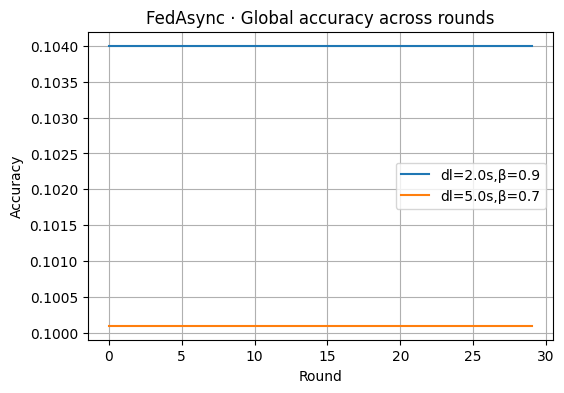

In [23]:
# ============================================================
# 3‑05 🚀  Run two scenarios & compare
# ============================================================
results = []
acc_curves = {}

cfgs = [(2.0, 0.9), (5.0, 0.7)]   # (deadline s, beta)
for dl, bt in cfgs:
    res, curve = run_fedasync(dl, bt,
                              desc='FedAsync heterogeneous system')
    results.append(res); acc_curves[f'dl={dl}s,β={bt}'] = curve

# -- table‑like printout ------------------------------------------------------
print('\nSummary:')
print('┌────┬──────────┬─────────┬──────────┬────────────┬────────────┐')
print('│ #  │ deadline │  beta   │ on‑time  │  dropped   │ acc (R30)  │')
print('├────┼──────────┼─────────┼──────────┼────────────┼────────────┤')
for i, r in enumerate(results, 1):
    print(f'│ {i:<2} │ {r["deadline"]:>8.1f}s │ {r["beta"]:>5.2f}  │'
          f' {r["on_time"]:>8} │ {r["dropped"]:>9} │ {r["acc"]*100:>6.2f}% │')
print('└────┴──────────┴─────────┴──────────┴────────────┴────────────┘')

# -- accuracy curve plot ------------------------------------------------------
plt.figure(figsize=(6,4))
for lbl, curve in acc_curves.items():
    plt.plot(curve, label=lbl)
plt.title('FedAsync · Global accuracy across rounds')
plt.xlabel('Round'); plt.ylabel('Accuracy'); plt.grid(); plt.legend(); plt.show()
